In [1]:
import cv2
# from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from threading import Thread

from scipy.spatial import Delaunay
import scipy.misc
from scipy.spatial import distance

import dlib

In [2]:
# Data from: https://huggingface.co/datasets/wider_face
# unzip files into 'data' folder

data_dir            = 'data'

training_img_dir    = '/WIDER_train/images/'
test_img_dir        = '/WIDER_test/images/'
validation_img_dir  = '/WIDER_val/images/'

label_dir           = '/wider_face_split'
training_img_label  = '/wider_face_train_bbx_gt.txt'
val_img_label       = '/wider_face_val_bbx_gt.txt'

In [3]:
training_data = []

with open(data_dir + label_dir + training_img_label) as t:
    line = t.readline().strip('\n')
    num_img, max_img = 0, 50

    while line:
        if 'jpg' in line:
            num_img += 1
            if num_img > max_img:
                num_img -= 1
                break

            # If we need anything beyond bbx and img from data, 
            # uncomment the commented dictionary and data parsing bits below
            training_data.append({
                'img': cv2.cvtColor(cv2.imread(data_dir + training_img_dir + line, -1), cv2.COLOR_BGR2RGB),
                # 'img': Image.open(data_dir + training_img_dir + line),
                'bbx': [],
                # 'blur': [],
                # 'expression': [],
                # 'illumination': [],
                # 'occulsion': [],
                # 'pose': [],
                # 'invalid': []
            })

        else:
            if line.isnumeric(): # number of face bbx
                line = t.readline().strip('\n')
                continue
            else:
                face_data = line.split(' ')
                training_data[-1]['bbx'].append([int(coord) for coord in face_data[:4]])
                # training_data[-1]['blur'].append(int(face_data[4]))
                # training_data[-1]['expression'].append(int(face_data[5]))
                # training_data[-1]['illumination'].append(int(face_data[6]))
                # training_data[-1]['occulsion'].append(int(face_data[7]))
                # training_data[-1]['pose'].append(int(face_data[8]))
                # training_data[-1]['invalid'].append(not bool(face_data[9]))
        line = t.readline().strip('\n')

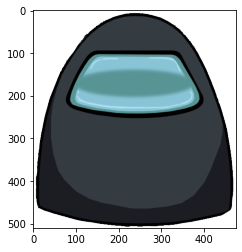

In [4]:
amongus_dir = data_dir + '/amongus'
among_us_faces = [cv2.cvtColor(cv2.imread(f'{amongus_dir}/{file}', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)[140:650, 175:650] # resize config
            for file in os.listdir(amongus_dir)]

# crop_config = (175, 140, 650, 650) # left, top, right bottom
# among_us = [Image.open(f'{amongus_dir}/{file}').crop(crop_config)
#             for file in os.listdir(amongus_dir)]
plt.imshow(among_us_faces[0])
plt.show()

# Resize Amongus Face from BBX

1


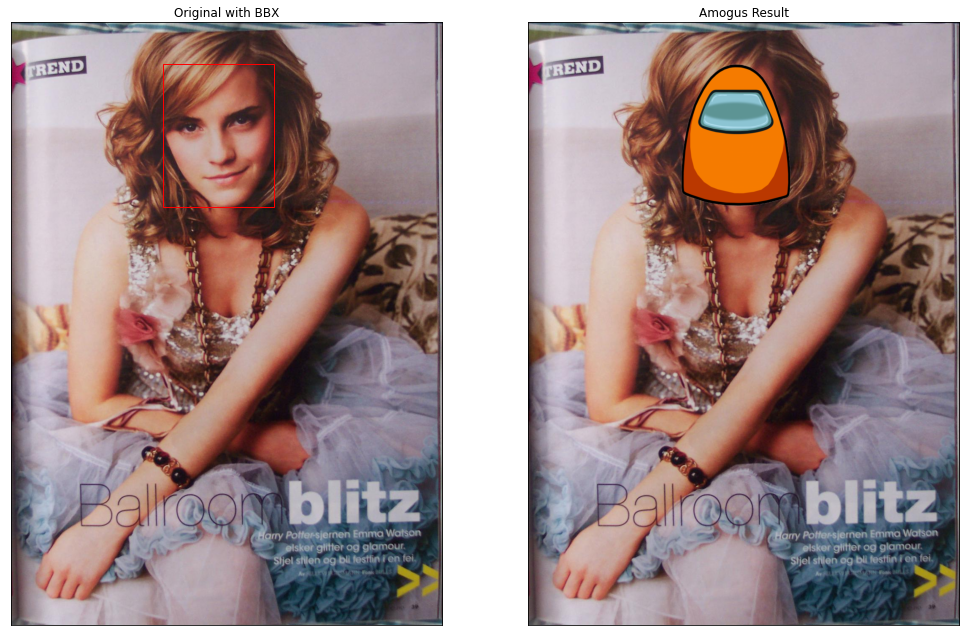

In [74]:
# i = np.random.randint(0, len(training_data))
def among_us_face(i, figsize=(17,20)):
    print(i)

    train_img = training_data[i]['img']
    amongus_res = train_img.copy()
    threads = []

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(train_img)
    axes[0].set_title('Original with BBX'), axes[0].set_xticks([]), axes[0].set_yticks([])

    def threading_amongus(bbx):
        a, b, width, height = bbx
        # resize a randomly chosen among-us face
        amongus = cv2.resize(among_us[np.random.randint(0, len(among_us))], (width, height), interpolation=cv2.INTER_AREA)

        # assign among-us face to the global result
        alpha = amongus[:, :, 3] / 255.0
        for channel in range(3):
            amongus_res[b:b+height, a:a+width, channel] = (1. - alpha) * train_img[b:b+height, a:a+width, channel] + alpha * amongus[:, :, channel]

        # add bounding box for the first image
        rect = patches.Rectangle((a, b), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)

    # parallellize the resizing & assigning of amongus faces
    for bbx in training_data[i]['bbx']:
        threads.append(Thread(target=threading_amongus, args=(bbx,)))
        threads[-1].start()

    # join all threads
    for thread in threads:
        thread.join()

    axes[1].imshow(amongus_res)
    axes[1].set_title('Amogus Result'), axes[1].set_xticks([]), axes[1].set_yticks([])
    plt.show()

among_us_face(1)

# Detect Feature Points and Warp

In [37]:
a, b, width, height = bbx # image 1 only has 1 bbx
sub_img = train_img[b:b+height, a:a+width]
res_img = res[b:b+height, a:a+width]

def get_face_landmarks(img):
    detector = dlib.get_frontal_face_detector()
    # download predictor from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    predictor = dlib.shape_predictor('data/shape_predictor_68_face_landmarks.dat') 

    dets = detector(img, 1)
    if len(dets) == 0:
        dets = dlib.rectangles()
        dets.append(dlib.rectangle(-32, 0, img.shape[0], img.shape[1]))
    
    pts = np.zeros((68, 2), np.int32)
    y, x = img.shape[:2]
    for d in dets:
        shape = predictor(img, d) # get landmark

        for i in range(68):
            coord = shape.part(i)
            if coord.x < x:
                pts[i, 0] = coord.x
            else:
                pts[i, 0] = x - 1

            if coord.y < y:
                pts[i, 1] = coord.y
            else:
                pts[i, 1] = y - 1
    
    return pts

In [38]:
original_lm = get_face_landmarks(sub_img)
amongus_lm = get_face_landmarks(res_img) # should only be computed once

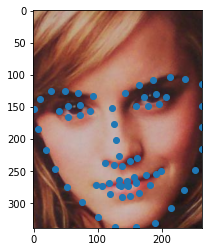

In [39]:
plt.imshow(sub_img)
plt.plot([x for x, _ in original_lm], [y for _, y in original_lm], 'o')
plt.show()

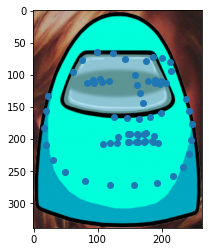

In [40]:
plt.imshow(res_img)
plt.plot([x for x, _ in amongus_lm], [y for _, y in amongus_lm], 'o')
plt.show()

As can be seen above, the automatic feature finding algorithm doesn't work for the Among Us face. We manually mapped the feature points to fix this.

# Feature points for Among Us Face

In [42]:
# Manually assigned text file of among us feature points
with open('data/amongus_points.txt') as f:
    feature_points = f.readlines()

amongus_feature_points = []
for index, point in enumerate(feature_points):
    coord = point.strip()
    x,y = coord.split(',')
    x = int(x)
    y = int(y)
    amongus_feature_points.append((x,y))
amongus_feature_points = np.array(amongus_feature_points)
amongus_feature_points -= (175,143) # For some reason the tool I used had an offset

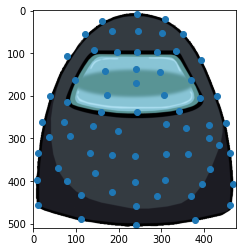

In [43]:
# Manually mapped feature points
plt.imshow(among_us[0])
amongus_x_feature = amongus_feature_points[:,0]
amongus_y_feature = amongus_feature_points[:,1]
plt.plot(amongus_x_feature, amongus_y_feature, 'o')
plt.show()

In [44]:
# Feature points can be remapped by using a ratio of new_dim/old_dim
def resize_amongus_features(x_feature, y_feature, new_width, new_height, image):
    height, width, _ = image.shape
    resized_feature_x = amongus_x_feature * (new_width/width)
    resized_feature_y = amongus_y_feature * (new_height/height)
    return resized_feature_x.astype(int), resized_feature_y.astype(int)

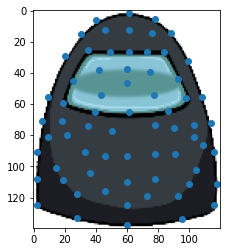

In [45]:
new_width = 120
new_height = 140
resized_amongus = cv2.resize(among_us[0], (new_width, new_height))
plt.imshow(resized_amongus)
resized_feature_x,resized_feature_y = resize_amongus_features(amongus_x_feature, amongus_y_feature, new_width, new_height, among_us[0])
plt.plot(resized_feature_x, resized_feature_y, 'o')
plt.show()

# Resized Among Us face with feature points

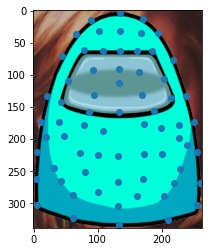

In [46]:
new_height, new_width, _ = res_img.shape
resized_feature_x, resized_feature_y = resize_amongus_features(amongus_x_feature, amongus_y_feature, new_width, new_height, among_us[0])
plt.imshow(res_img)
plt.plot(resized_feature_x, resized_feature_y, 'o')
plt.show()

In [47]:
# Get arrays of feature points
among_us_point = np.vstack((resized_feature_x, resized_feature_y)).T # Combine x and y feature coords into one array
orig_point = np.array([[x,y] for x,y in original_lm])
# Get index of which Among Us points are closest to the original feature points
# closest = np.zeros(orig_point.shape, dtype=int)
# dist = distance.cdist(orig_point, among_us_point)
# min_index = np.argmin(dist, axis=1) # Indices of Among Us feature points nearest to the original image feature point

# Affine Transformation

In [48]:
# "alpha blend" for two sets of points
def weighted_avg_pts(start_pts, end_pts, percentage):
    return np.array(start_pts * percentage + end_pts * (1 - percentage))

# alpha blend for two images
def weighted_avg_img(start_img, end_img, percentage):
    return cv2.addWeighted(start_img, percentage, end_img, 1 - percentage, 0)

In [49]:
among_us_point = np.vstack((resized_feature_x, resized_feature_y)).T # Combine x and y feature coords into one array
orignal_point  = np.array([[x,y] for x,y in original_lm])

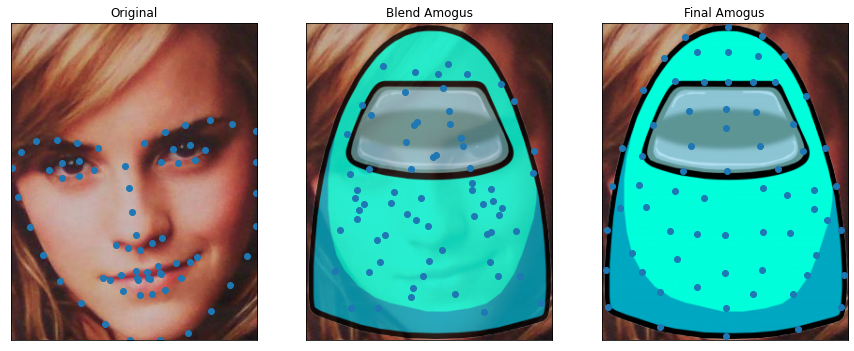

In [50]:
blended_points = weighted_avg_pts(orignal_point, among_us_point, percentage=0.2)
blended_image  = weighted_avg_img(sub_img, res_img, percentage=0.2)

fig, axes = plt.subplots(1, 3, figsize=(15,17))
axes[0].imshow(sub_img)
axes[0].set_title('Original'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[0].plot([x for x, _ in original_lm], [y for _, y in original_lm], 'o')

axes[1].imshow(blended_image)
axes[1].set_title('Blend Amogus'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[1].plot([x for x, _ in blended_points], [y for _, y in blended_points], 'o')

axes[2].imshow(res_img)
axes[2].set_title('Final Amogus'), axes[2].set_xticks([]), axes[2].set_yticks([])
axes[2].plot(resized_feature_x, resized_feature_y, 'o')
plt.show()

## The helper functions

In [51]:
# binlinear interpolation over all channel
def bilinear_interpolate(im, points):
    # derived from https://stackoverflow.com/questions/12729228/simple-efficient-bilinear-interpolation-of-images-in-numpy-and-python
    x, y = points
    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1]-1)
    x1 = np.clip(x1, 0, im.shape[1]-1)
    y0 = np.clip(y0, 0, im.shape[0]-1)
    y1 = np.clip(y1, 0, im.shape[0]-1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    a = np.concatenate([[wa]] * 3, axis=0).T * Ia
    b = np.concatenate([[wb]] * 3, axis=0).T * Ib
    c = np.concatenate([[wc]] * 3, axis=0).T * Ic 
    d = np.concatenate([[wd]] * 3, axis=0).T * Id
    return a + b + c + d

# return an array of possible coordinates within the region-of-interest
def region_of_interest(points):
    min_x, min_y = int(np.min(points[:,0])), int(np.min(points[:,1]))
    max_x, max_y = int(np.max(points[:,0])) + 1, int(np.max(points[:,1])) + 1
    
    return np.asarray([(x, y) for x in range(min_x, max_x) for y in range(min_y, max_y)])

# warp the triangle from start to end image, inside the region-of-interest
def warp(start_img, end_img, delaunay:Delaunay, points, triangular_affine_matrix):
    roi = region_of_interest(points)
    roi_triangular_idx = delaunay.find_simplex(roi)
    
    for i in range(len(delaunay.simplices)):
        start_pts = roi[i == roi_triangular_idx]
        end_pts = np.dot(triangular_affine_matrix[i],
                         np.vstack((start_pts.T, np.ones(len(start_pts)))))
        x, y = start_pts.T
        # directly warp the input end_img
        end_img[y, x] = bilinear_interpolate(start_img, end_pts)


In [52]:
# compute affine transformation matrix for a triangle vertices, from given points
def tri_affine_matrix(start_pts, end_pts, tri_pts):
    for i in tri_pts:
        start_t = np.vstack((start_pts[i, :].T, [1, 1, 1]))
        end_t   = np.vstack((end_pts[i,:].T, [1, 1, 1]))
        mat = np.dot(start_t, np.linalg.inv(end_t))[:2, :]
        yield mat # stop at each pts

def warp_image(start_img, start_pts, end_pts):
    delaunay = Delaunay(end_pts)
    end_img = np.zeros(start_img.shape, np.uint8)

    matrix = tri_affine_matrix(start_pts, end_pts, delaunay.simplices)
    tri_affine = np.asarray(list(matrix))

    warp(start_img, end_img, delaunay, end_pts, tri_affine)
    return end_img

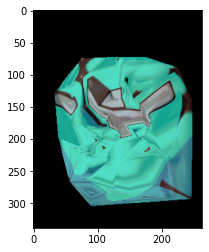

In [53]:
test_per = 0.4
blended_points = weighted_avg_pts(orignal_point, among_us_point, percentage=test_per)

# get the warped results from both end
start_face = warp_image(sub_img, orig_point, blended_points)
end_face = warp_image(res_img, among_us_point, blended_points)

blend = weighted_avg_img(start_face, end_face, test_per)

plt.imshow(blend)

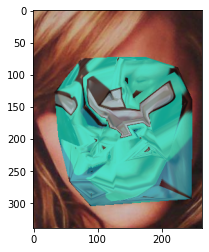

In [54]:
test_assign = sub_img.copy()
test_assign = np.where(blend != 0, blend, test_assign)
plt.imshow(test_assign)

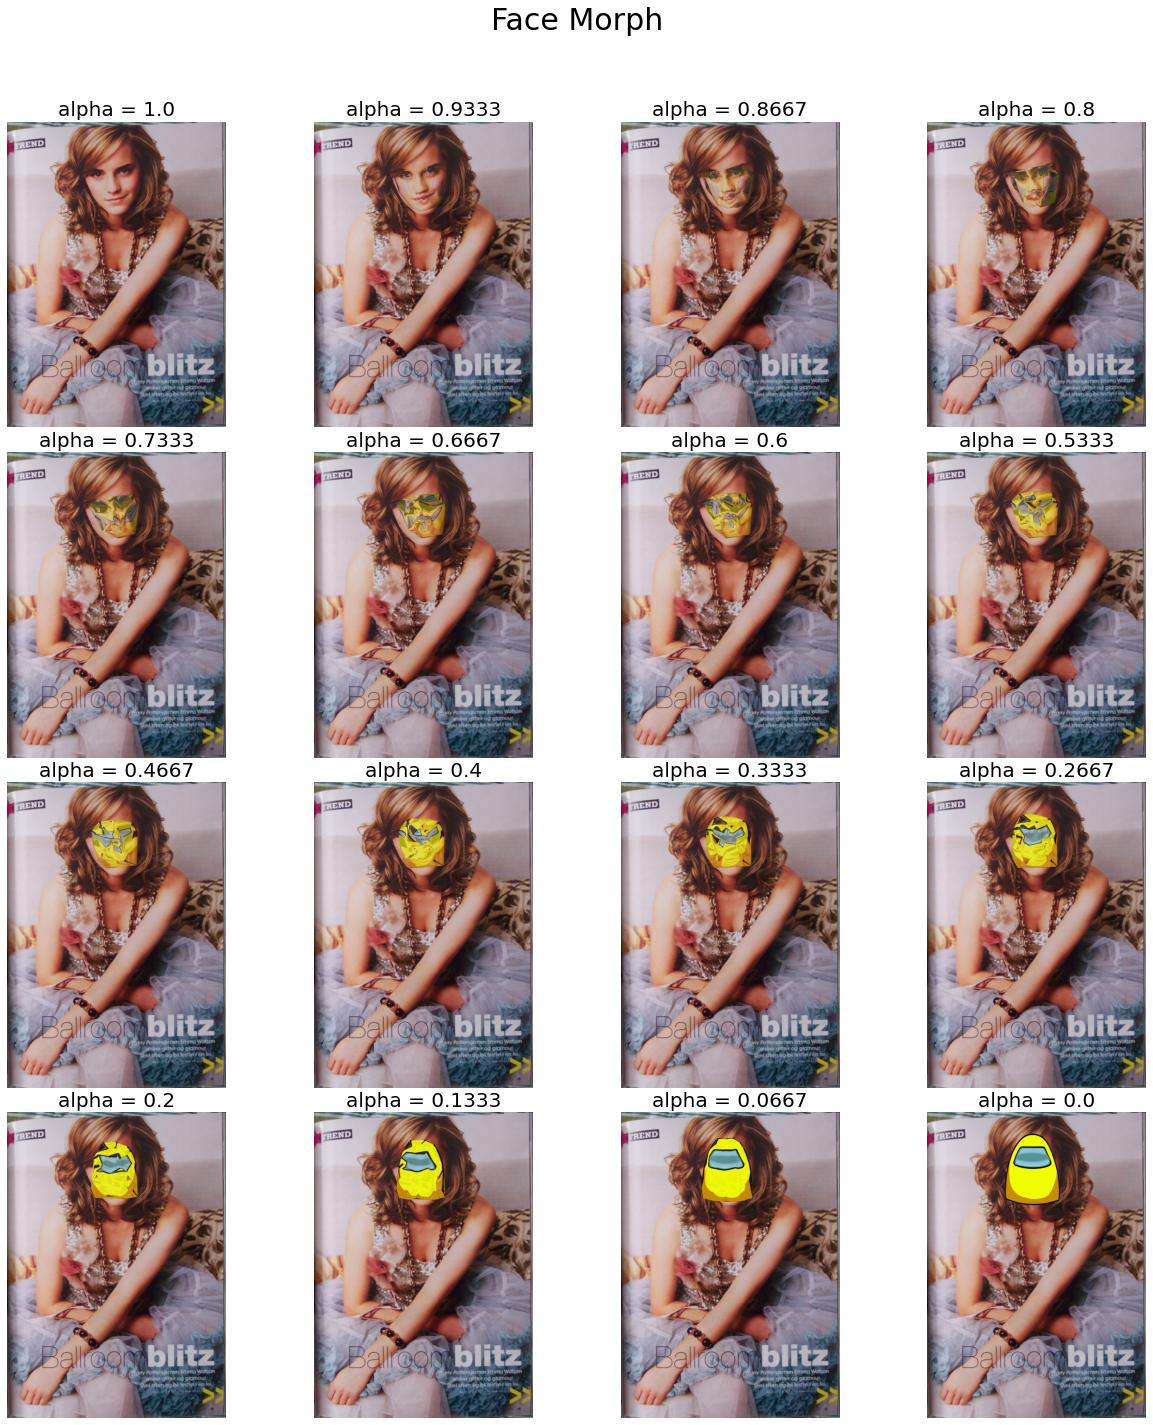

In [62]:
def face_morph(start_img, start_lm_points, end_img, end_lm_points, bbx):
    fig = plt.figure(figsize=(17, 20))
    fig.subplots_adjust(top=0.9, bottom=0, left=0, right=1, wspace=0.01, hspace=0.08)

    a, b, width, height = bbx # image 1 only has 1 bbxs

    i = 1
    for alpha in np.linspace(1, 0, 16):
        # saves time on alpha 1 and 0
        if alpha != 0 and alpha != 1:
            final_assign = start_img.copy()
            # get the blended points
            blended_points = weighted_avg_pts(start_lm_points, end_lm_points, percentage=alpha)

            # get the warped results from both end
            start_face = warp_image(start_img[b:b+height, a:a+width], start_lm_points, blended_points)
            end_face   = warp_image(end_img[b:b+height, a:a+width], end_lm_points, blended_points)

            # alpha blend the results
            blended_image  = weighted_avg_img(start_face, end_face, percentage=alpha)

            final_assign[b:b+height, a:a+width] = np.where(blended_image != 0, blended_image, start_img[b:b+height, a:a+width])

        else:
            final_assign = (end_img, start_img)[int(alpha)]

        plt.subplot(4,4,i)
        plt.imshow(final_assign)
        plt.title(f'alpha = {round(alpha, 4)}', size=20)
        plt.axis('off')
        
        i += 1

    plt.suptitle('Face Morph', size=30)
    plt.show()

face_morph(train_img, orig_point, amongus_res, among_us_point)

# Multi-face Morph

In [5]:
# classses
%reload_ext autoreload
from amongus import Amongus_Image
from affine_transform import Affine_Transform

In [18]:
i = 7
amongus_img = Amongus_Image(training_data[i]['img'],
                            among_us_faces,
                            training_data[i]['bbx'])

In [19]:
amongus_img.generate_amongus()

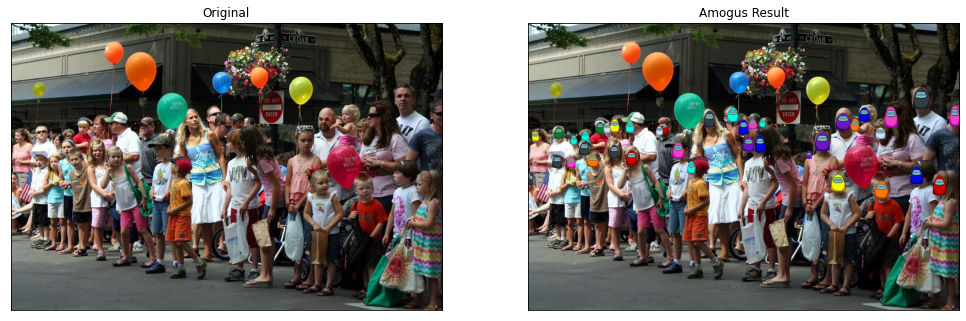

In [20]:
amongus_img.display_amongus()
# query orignal & final image as amongus_img.start_img & amongus_img.amongus_final

In [21]:
affine_transform = Affine_Transform(amongus_img)

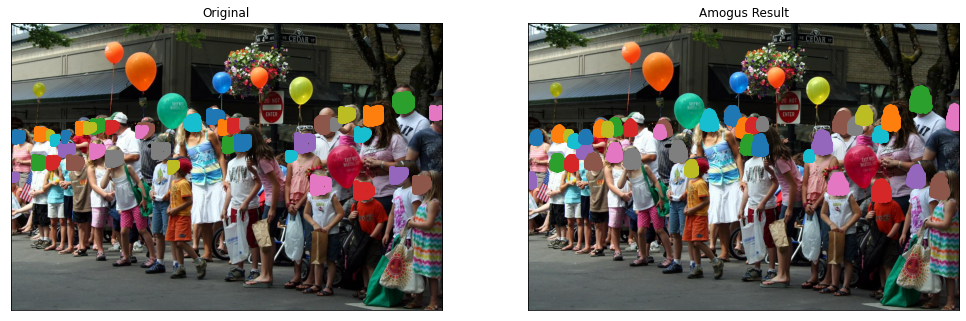

In [22]:
affine_transform.display_features() # face is too small so it clumps up the points

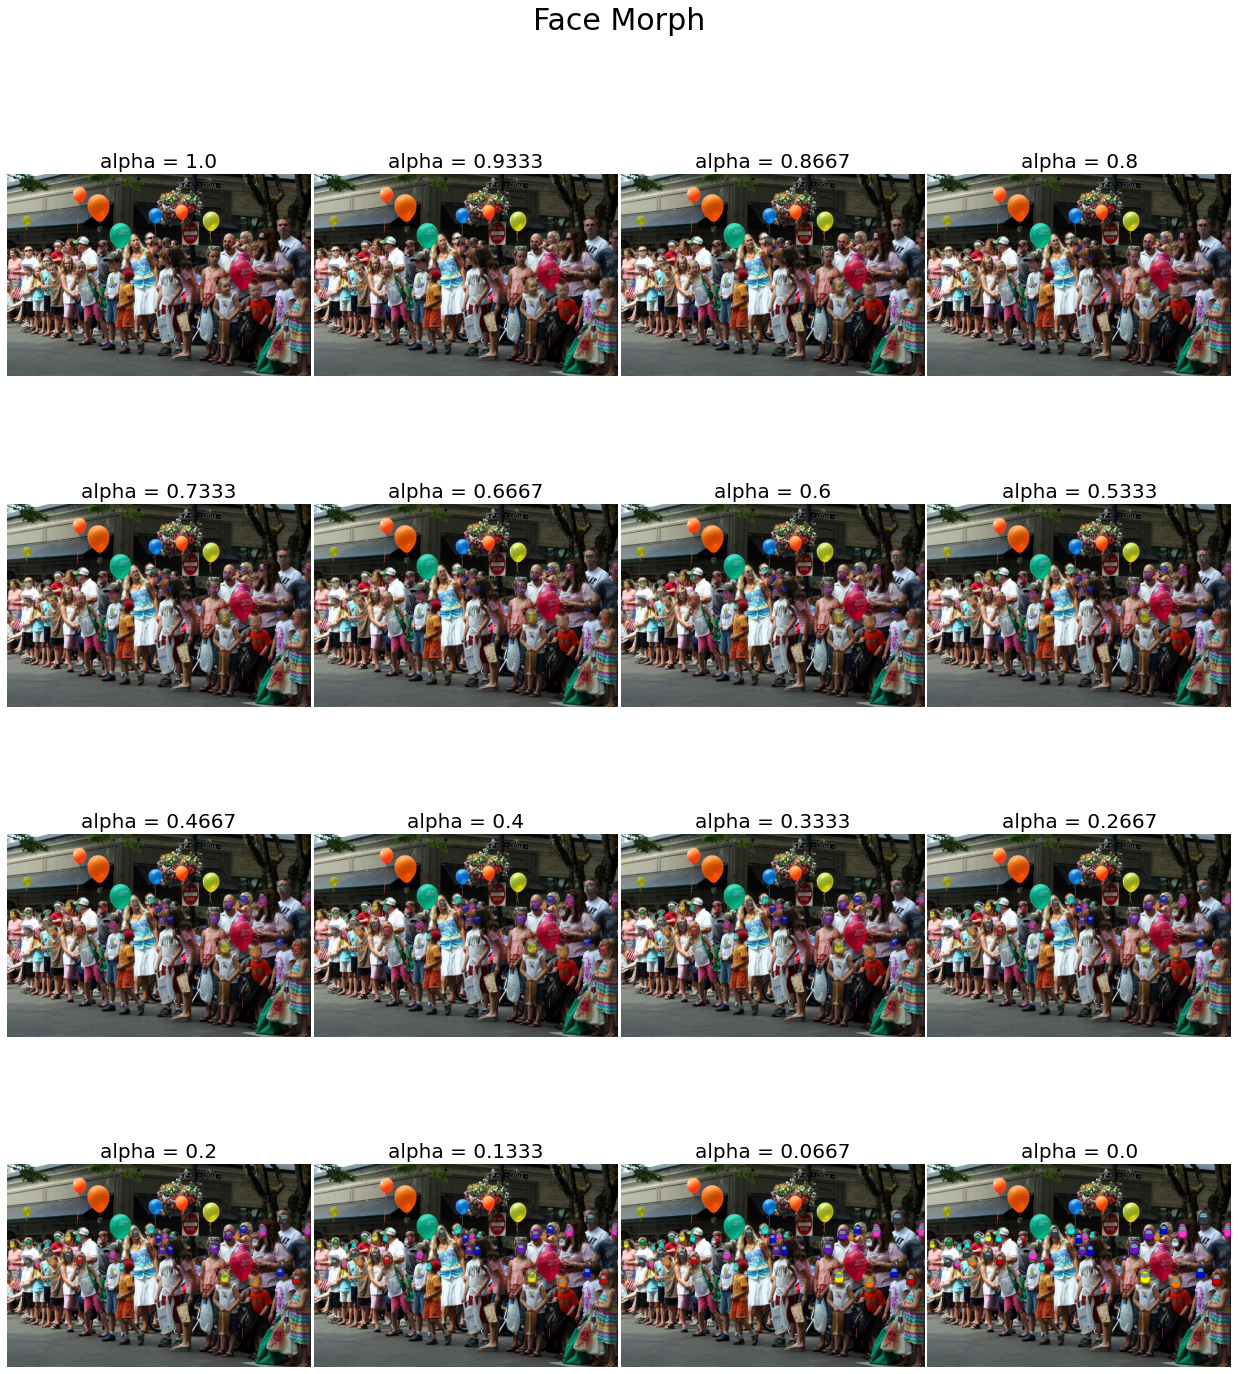

In [23]:
affine_transform.face_morph_test()